Для проверки роботоспособности достаточно запустить вкладку "тест модели", ничего скачивать дополнительно не нужно.

#Определение пола

##подготовка данных

In [ ]:
# Работа с массивами
import numpy as np

# Генератор аугментированных изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Основа для создания последовательной модели
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Подключение модуля для загрузки данных из облака
import gdown

# Инструменты для работы с файлами
import os

# Отрисовка графиков
import matplotlib.pyplot as plt

# Рисование графиков в ячейках Colab
%matplotlib inline

from PIL import Image                     # Отрисовка изображений
import random                             # Генерация случайных чисел
import matplotlib.pyplot as plt           # Отрисовка графиков
import gc


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qo "/content/drive/MyDrive/Colab Notebooks/Дипломный проект/gender.zip" -d {"/content/gender"}

In [ ]:
# Задание гиперпараметров

TRAIN_PATH          = '/content/gender/Training/'       # Папка для обучающего набора данных
TEST_PATH           = '/content/gender/Validation/'  # Папка для тестового набора данных

IMG_WIDTH           = 60                   # Ширина изображения для нейросети
IMG_HEIGHT          = 80                    # Высота изображения для нейросети
IMG_CHANNELS        = 3                     # Количество каналов (для RGB равно 3, для Grey равно 1)

CLASS_LIST = ['female', 'male']
CLASS_COUNT = len(CLASS_LIST)


In [ ]:
ROTATION_RANGE      = 8                     # Пределы поворота
WIDTH_SHIFT_RANGE   = 0.15                  # Пределы сдвига по горизонтали
HEIGHT_SHIFT_RANGE  = 0.15                  # Пределы сдвига по вертикали
ZOOM_RANGE          = 0.15                  # Пределы увеличения/уменьшения
BRIGHTNESS_RANGE    = (0.7, 1.3)            # Пределы изменения яркости
HORIZONTAL_FLIP     = True                  # Горизонтальное отражение разрешено

In [ ]:
train_datagen = ImageDataGenerator(
                    rescale=1. / 255.,
                    rotation_range=ROTATION_RANGE,
                    width_shift_range=WIDTH_SHIFT_RANGE,
                    height_shift_range=HEIGHT_SHIFT_RANGE,
                    zoom_range=ZOOM_RANGE,
                    brightness_range=BRIGHTNESS_RANGE,
                    horizontal_flip=HORIZONTAL_FLIP
                )
val_datagen = ImageDataGenerator(
                    rescale=1. / 255.,
                    rotation_range=ROTATION_RANGE,
                    width_shift_range=WIDTH_SHIFT_RANGE,
                    height_shift_range=HEIGHT_SHIFT_RANGE,
                    zoom_range=ZOOM_RANGE,
                    brightness_range=BRIGHTNESS_RANGE,
                    horizontal_flip=HORIZONTAL_FLIP,
                    validation_split=0.99
                )

In [ ]:
train_generator = train_datagen.flow_from_directory(
    # Путь к обучающим изображениям
    TRAIN_PATH,
    # Параметры требуемого размера изображения
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    # Размер батча
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать обучающую выборку
    subset='training'
)

# Проверочная выборка также генерируется из папки обучающего набора
validation_generator = val_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать проверочную выборку
    subset='validation'
)

Found 47009 images belonging to 2 classes.
Found 11531 images belonging to 2 classes.


##Архитектура

In [ ]:
def residual_block(x, filters, kernel_size=3, stride=1, dropout_rate=0.0):
    # Короткое соединение
    shortcut = x

    # Первый сверточный слой
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout_rate > 0.0:
        x = Dropout(dropout_rate)(x)

    # Второй сверточный слой
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Корректировка размерностей короткого соединения
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, strides=stride, padding='same')(shortcut)

    # Добавление короткого соединения к выходу
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x


def build_resnet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=2, dropout_rate=0.0):
    # Input layer
    input_layer = Input(shape=input_shape)

    # Initial convolution
    x = Conv2D(64, 7, strides=2, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual blocks
    x = residual_block(x, 64, dropout_rate=dropout_rate)
    x = residual_block(x, 64, dropout_rate=dropout_rate)

    x = residual_block(x, 128, stride=2, dropout_rate=dropout_rate)
    x = residual_block(x, 128, dropout_rate=dropout_rate)

    x = residual_block(x, 256, stride=2, dropout_rate=dropout_rate)
    x = residual_block(x, 256, dropout_rate=dropout_rate)

    x = GlobalAveragePooling2D()(x)

    # Fully connected layers
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    output_layer = Dense(num_classes, activation='softmax')(x)

    # Create and compile the model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Параметры модели
IMG_WIDTH = 60
IMG_HEIGHT = 80
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
num_classes = 2

# Построение модели ResNet
model = build_resnet(input_shape=input_shape, num_classes=num_classes, dropout_rate=0.3)

# Вывод структуры модели
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 80, 60, 3)]          0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 40, 30, 64)           9472      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_13 (Ba  (None, 40, 30, 64)           256       ['conv2d_15[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_13 (Activation)  (None, 40, 30, 64)           0         ['batch_normalization_13

In [ ]:
from keras.callbacks import ModelCheckpoint

# Создаем колбек для сохранения лучшей модели
model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5',  # Путь к файлу для сохранения модели
    monitor='val_loss',         # Мониторим валидационную потерю
    save_best_only=True,        # Сохраняем только лучшие (минимальные) значения
    mode='min',                 # Минимизация потерь
    verbose=1                    # Выводим сообщения
)

##Обучение и графики

In [ ]:
gc.collect()
store_learning = model.fit(train_generator,
                           validation_data=validation_generator,
                           epochs=20,
                           callbacks=[model_checkpoint],
                           verbose=1)

Epoch 1/20
1470/1470 [==============================] - ETA: 0s - loss: 0.4358 - accuracy: 0.7753
Epoch 1: val_loss improved from inf to 0.25778, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1470/1470 [==============================] - 212s 139ms/step - loss: 0.4358 - accuracy: 0.7753 - val_loss: 0.2578 - val_accuracy: 0.8991
Epoch 2/20
1470/1470 [==============================] - ETA: 0s - loss: 0.2043 - accuracy: 0.9230
Epoch 2: val_loss improved from 0.25778 to 0.24255, saving model to best_model.h5
1470/1470 [==============================] - 176s 120ms/step - loss: 0.2043 - accuracy: 0.9230 - val_loss: 0.2426 - val_accuracy: 0.9050
Epoch 3/20
1470/1470 [==============================] - ETA: 0s - loss: 0.1701 - accuracy: 0.9377
Epoch 3: val_loss improved from 0.24255 to 0.14023, saving model to best_model.h5
1470/1470 [==============================] - 190s 129ms/step - loss: 0.1701 - accuracy: 0.9377 - val_loss: 0.1402 - val_accuracy: 0.9450
Epoch 4/20
1470/1470 [==============================] - ETA: 0s - loss: 0.1558 - accuracy: 0.9432
Epoch 4: val_loss improved from 0.14023 to 0.13777, saving model to best_model.h5
1470/1470 [==============================] - 179s

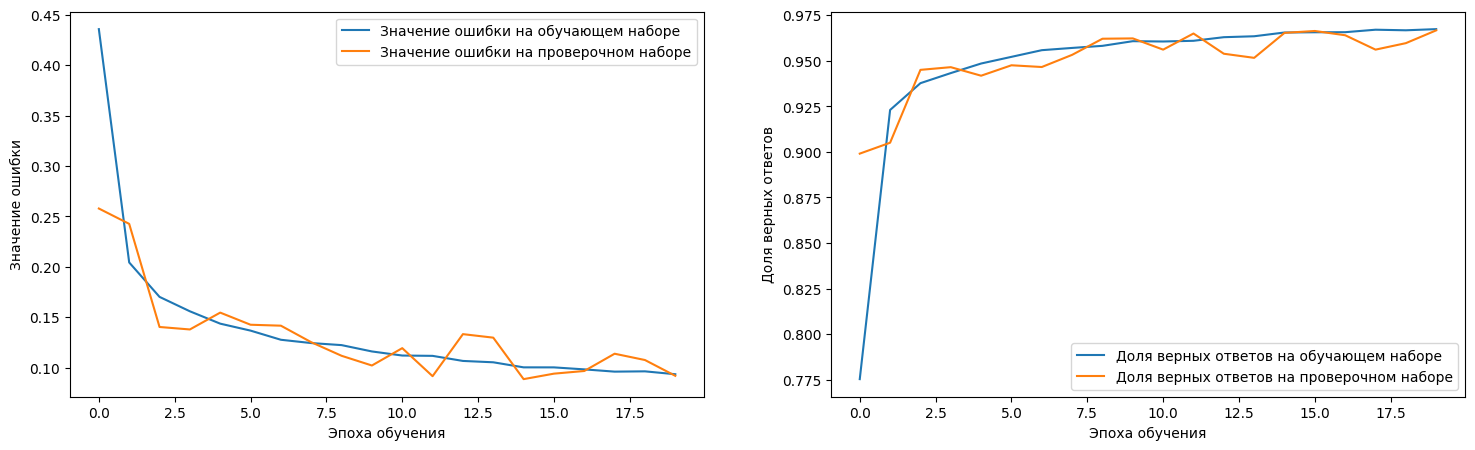

In [ ]:
# Создание полотна для рисунка
plt.figure(1, figsize=(18, 5))

# Задание первой (левой) области для построения графиков
plt.subplot(1, 2, 1)
# Отрисовка графиков 'loss' и 'val_loss' из значений словаря store_learning.history
plt.plot(store_learning.history['loss'],
         label='Значение ошибки на обучающем наборе')
plt.plot(store_learning.history['val_loss'],
         label='Значение ошибки на проверочном наборе')
# Задание подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()

# Задание второй (правой) области для построения графиков
plt.subplot(1, 2, 2)
# Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря store_learning.history
plt.plot(store_learning.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(store_learning.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
# Задание подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

# Фиксация графиков и рисование всей картинки
plt.show()

##Тест модели

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import requests
import h5py
from io import BytesIO
import tensorflow as tf

def load_model_from_h5_url(url):
    # Загрузка файла H5 из URL
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception("Failed to download the H5 file")

    # Создание объекта BytesIO для чтения данных
    h5_data = BytesIO(response.content)

    # Чтение модели из файла H5
    with h5py.File(h5_data, 'r') as h5_file:
        model = tf.keras.models.load_model(h5_file)

    return model

model_url = 'https://drive.usercontent.google.com/u/0/uc?id=10GnjtA3Siy7NQShTojvJBWBE2zoo6B9z&export=download'
model = load_model_from_h5_url(model_url)

In [ ]:
import zipfile
import io
import os

def remove_folder(directory):
    if os.path.exists(directory):
        !rm -rf {directory}
        print(f"Папка '{directory}' успешно удалена.")
    else:
        print(f"Папка '{directory}' не существует, поэтому её удаление не требуется.")

remove_folder('/content/test')

def download_and_extract_zip(url, extract_to='.'):
    # Загрузка файла ZIP
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception("Failed to download the ZIP file")

    # Разархивация файла ZIP
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        zip_ref.extractall(extract_to)

# URL для скачивания файла ZIP
zip_url = 'https://drive.usercontent.google.com/u/0/uc?id=1bNdRbAe0UM2hdiLLgCfmR2pP990CdbiJ&export=download'
extract_directory = '/content/test'
# Создание директории, если её нет
if not os.path.exists(extract_directory):
    os.makedirs(extract_directory)

# Загрузка и распаковка файла ZIP
download_and_extract_zip(zip_url, extract_directory)

Папка '/content/test' успешно удалена.


1/1 [==============================] - 2s 2s/step


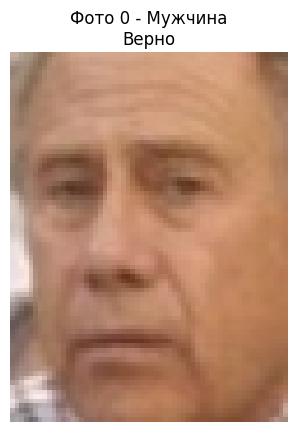

1/1 [==============================] - 0s 21ms/step


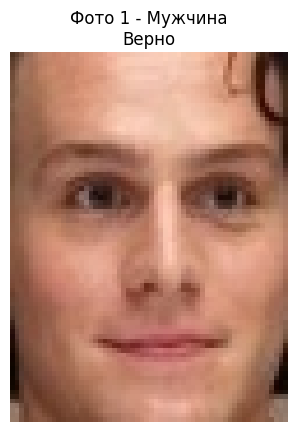

1/1 [==============================] - 0s 18ms/step


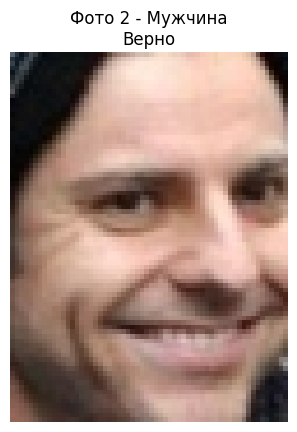

1/1 [==============================] - 0s 18ms/step


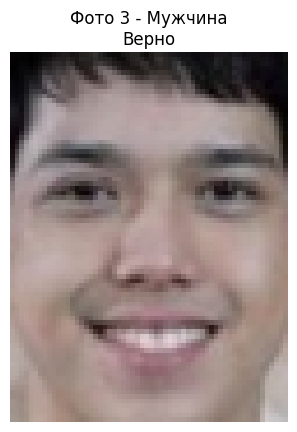

1/1 [==============================] - 0s 18ms/step


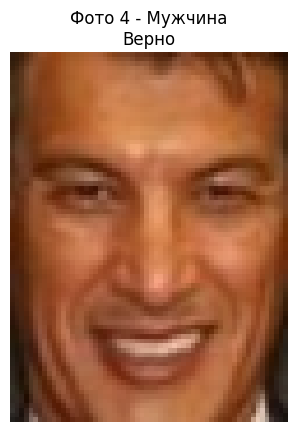

1/1 [==============================] - 0s 18ms/step


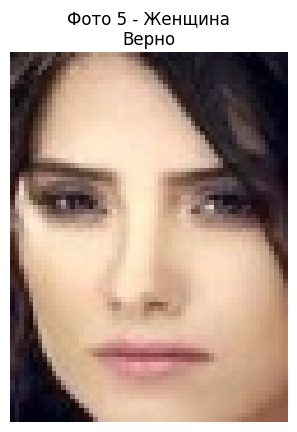

1/1 [==============================] - 0s 87ms/step


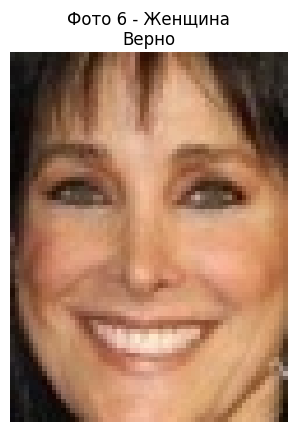

1/1 [==============================] - 0s 22ms/step


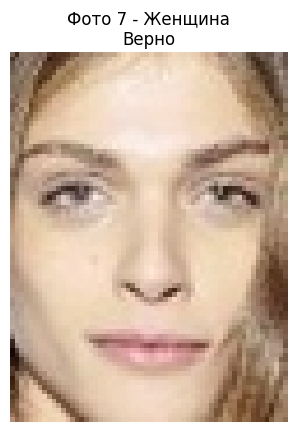

1/1 [==============================] - 0s 26ms/step


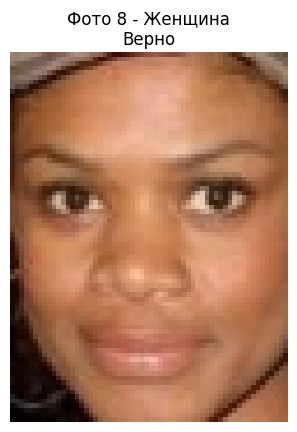

1/1 [==============================] - 0s 18ms/step


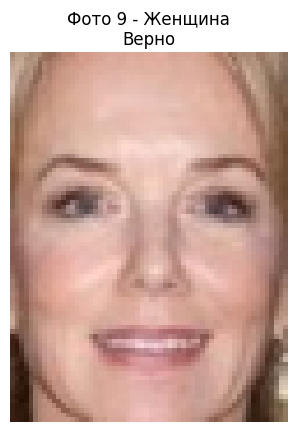

In [ ]:
import numpy as np

IMG_WIDTH = 60
IMG_HEIGHT = 80

for i in range(10):
    img = Image.open(f"/content/test/test/{i}.jpg")
    img_resized = img.resize((IMG_WIDTH, IMG_HEIGHT))

    img_np = np.array(img_resized) / 255.0

    # Убедитесь, что размер изображения соответствует ожидаемому размеру (80x60x3)
    assert img_np.shape == (IMG_HEIGHT, IMG_WIDTH, 3), f"Неверный размер изображения {i}.jpg: {img_np.shape}"

    input_data = np.expand_dims(img_np, axis=0)

    # Запуск модели на изображении
    x = model.predict(input_data)
    if x.argmax() == 0:
        gender = 'Женщина'
        if i < 5:
            accuracy = 'Ошибка'
        else:
            accuracy = 'Верно'
    else:
        gender = 'Мужчина'
        if i > 4:
            accuracy = 'Ошибка'
        else:
            accuracy = 'Верно'

    # Вывод изображения с подписью
    plt.imshow(img_resized)
    plt.title(f"Фото {i} - {gender}\n{accuracy}")
    plt.axis('off')
    plt.show()

#Определение возраста

##Подготовка данных

In [ ]:
# подключаем нужные библиотеки и модули
import os.path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalMaxPool2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Nadam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import mean_absolute_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -qo '/content/drive/MyDrive/final_files.zip' -d {"/content/age"}

In [ ]:
# файл с метриками
labels_path = '/content/drive/MyDrive/labels.csv'

# директория с картинками
faces_path = "/content/age/final_files"

#путь сохранения нс
path_model_1 = '/content/drive/MyDrive/model_age.h5'

In [ ]:
# загружаем метрики в датафрейм
df = pd.read_csv(labels_path)

In [ ]:
# оценим содержимое
df.sample(5)

,file_name,real_age
4065,004065.jpg,61
224,000224.jpg,60
6676,006682.jpg,1
5,000005.jpg,27
7366,007388.jpg,69


In [ ]:
# общая информация
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
# есть ли дубли
df['file_name'].duplicated().sum()

0

In [ ]:
# характеристики
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


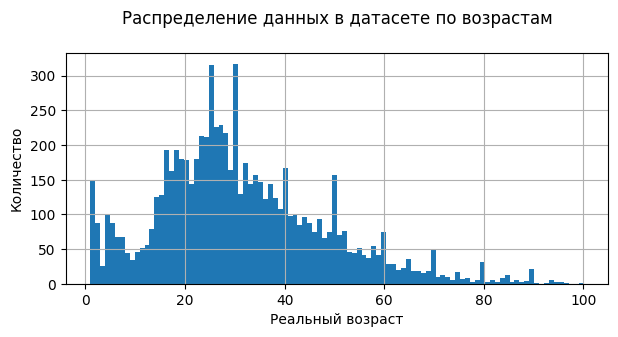

In [ ]:
# распределение возрастов
plt.figure(figsize=(7,3))
plt.title('Распределение данных в датасете по возрастам\n')
plt.xlabel('Реальный возраст')
plt.ylabel('Количество')
df.real_age.hist(bins=100);

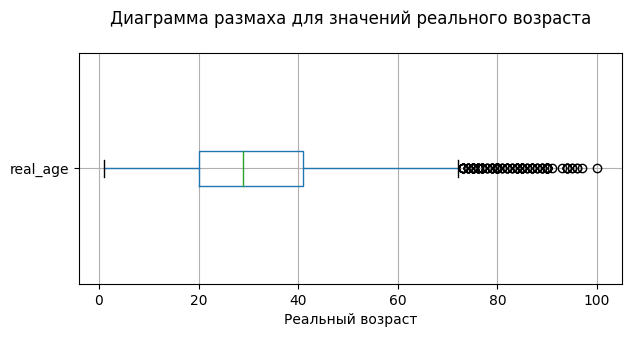

In [ ]:
# оценим выбросы
plt.figure(figsize=(7,3))
plt.title('Диаграмма размаха для значений реального возраста\n')
plt.xlabel('Реальный возраст')
df.boxplot('real_age', vert=False);

In [ ]:
# возрастные группы
df['age_cat'] = pd.cut(
    df.real_age,
    bins=[0, 11, 16, 20, 35, 59, 74, 89, 100],
    labels=['дети до 11 лет', 'подростки 12-15 лет', 'юноши 16-20 лет',
            'молодёж 21-35 лет', 'зрелый возраст 35-59 лет',
            'пожилые 60-74 года', 'старики 75-89 лет',
            'долгожители от 90 лет']
)

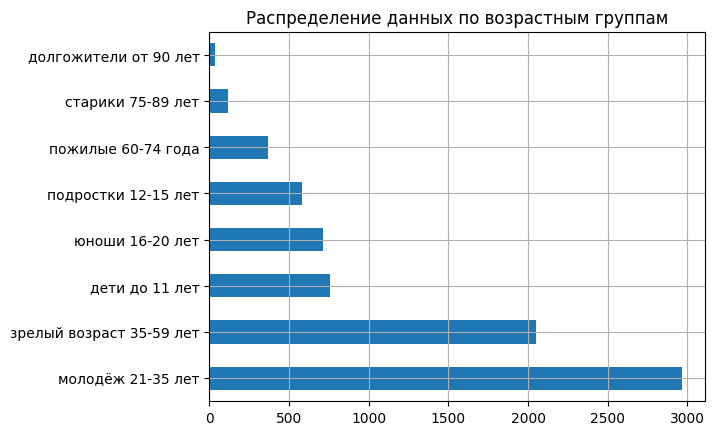

In [ ]:
df.age_cat.value_counts().plot(
    kind='barh', grid=True,
    title='Распределение данных по возрастным группам'
);

In [ ]:
# доли каждой из трех основных групп
kids = df['real_age'] < 21
mature = (df['real_age'] >= 21) & (df['real_age'] < 60)
elderly = df['real_age'] >= 60

print(f'''
Доля данных в датасете по возрастным группам:

1. дети: {kids.mean():.2%}
2. молодёжь и зрелый возраст: {mature.mean():.2%}
3. пожилые и старики: {elderly.mean():.2%}
''')


Доля данных в датасете по возрастным группам:

1. дети: 27.06%
2. молодёжь и зрелый возраст: 66.08%
3. пожилые и старики: 6.86%



In [ ]:
# число строк и колонок
rows = 5
columns = 4

# выборка произвольных данных
images = df.sample(rows*columns, random_state=12345)

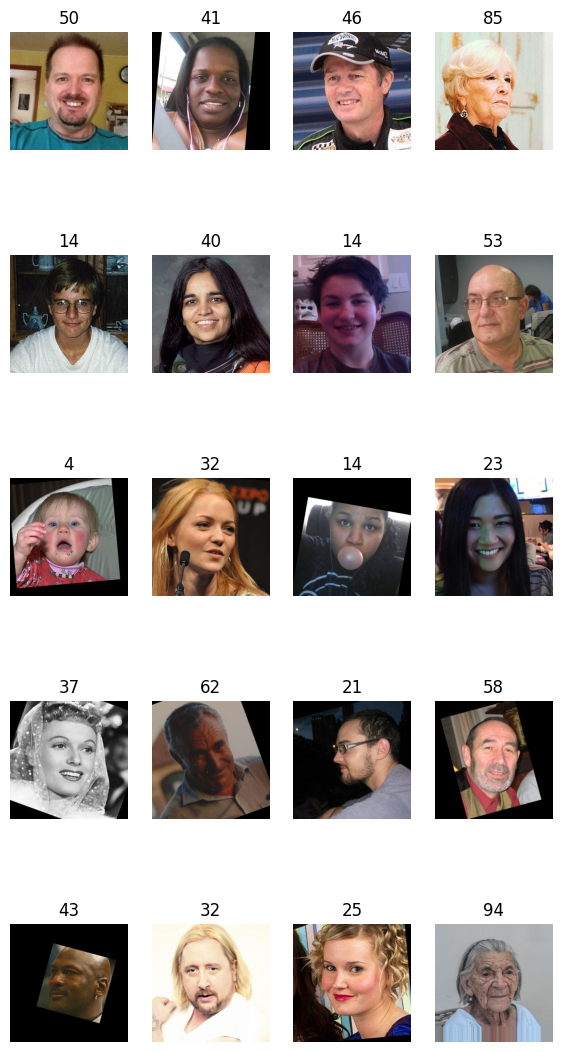

In [ ]:
# выведем изображения и данные возраста
fig = plt.figure(figsize=(7, 14))
for i in range(columns*rows):
    img = Image.open(os.path.join(faces_path, images.iloc[i]['file_name']))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(images.iloc[i]['real_age'])
plt.show()

In [ ]:
# создаём генератор тренировочной выборки
def load_train(pathl,pathph):
    dataframe = pd.read_csv(pathl)
    train_datagen = ImageDataGenerator(
        rescale=1.0/255, validation_split=0.25,
        horizontal_flip=True
    )
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe,
        directory=pathph,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        batch_size=32,
        shuffle=True,
        seed=12345,
        subset='training'
    )
    return train_datagen_flow

# создаём генератор тестовой выборки
def load_test(pathl,pathph):
    dataframe = pd.read_csv(pathl)
    test_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe,
        directory=pathph,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        batch_size=32,
        shuffle=True,
        seed=12345,
        subset='validation'
    )
    return test_datagen_flow


##Архитектура

In [ ]:
# создаём модель
def create_model(input_shape):
    optimizer = Nadam(learning_rate=0.0002)
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalMaxPool2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0,2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Инициализация переменной для отслеживания лучшей метрики
best_mae = float('inf')

# Функция для сохранения модели при улучшении метрики
def save_best_model(epoch, logs):
    global best_mae
    current_mae = logs.get('val_mae')
    if current_mae is not None and current_mae < best_mae:
        print(f"\nValidation MAE improved from {best_mae:.4f} to {current_mae:.4f}, saving model...")
        best_mae = current_mae
        keras.models.save_model(model, path_model_1, save_format='h5')
    else:
        print(f"\nValidation MAE did not improve from {best_mae:.4f}")

# Колбек для сохранения лучшей модели по метрике val_mae
callback_save_best_model = keras.callbacks.LambdaCallback(on_epoch_end=save_best_model)

##Обучение и графики

In [ ]:
# обучаем модель
def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):
    # условие оставновки по уровню ошибки
    stop_loss = EarlyStopping(
        monitor='val_loss', patience=15,
        verbose=1, restore_best_weights=True
    )
    # условие оставновки по метрике качества
    stop_mae = EarlyStopping(
        monitor='val_mae', patience=15,
        verbose=1, restore_best_weights=True
    )

    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size, epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=[stop_loss, stop_mae, callback_save_best_model],
        verbose=1
    )
    return model

In [ ]:
# создадим выборки
train_data = load_train(labels_path, faces_path)
test_data = load_test(labels_path, faces_path)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [ ]:
# создадим модель
model = create_model(input_shape = (224, 224, 3))

In [ ]:
# обучим модель
history = train_model(
    model, train_data, test_data, batch_size=None, epochs=20,
    steps_per_epoch=None, validation_steps=None)

Epoch 1/20
178/178 [==============================] - ETA: 0s - loss: 5.2532 - mae: 1.7287
Validation MAE did not improve from 5.5709
178/178 [==============================] - 75s 421ms/step - loss: 5.2532 - mae: 1.7287 - val_loss: 59.3597 - val_mae: 5.7414
Epoch 2/20
178/178 [==============================] - ETA: 0s - loss: 5.8599 - mae: 1.8229
Validation MAE did not improve from 5.5709
178/178 [==============================] - 78s 439ms/step - loss: 5.8599 - mae: 1.8229 - val_loss: 72.5553 - val_mae: 6.2140
Epoch 3/20
178/178 [==============================] - ETA: 0s - loss: 6.6331 - mae: 1.9187
Validation MAE did not improve from 5.5709
178/178 [==============================] - 75s 421ms/step - loss: 6.6331 - mae: 1.9187 - val_loss: 59.1508 - val_mae: 5.6613
Epoch 4/20
178/178 [==============================] - ETA: 0s - loss: 6.4477 - mae: 1.9305
Validation MAE did not improve from 5.5709
178/178 [==============================] - 74s 416ms/step - loss: 6.4477 - mae: 1.9305 - 

<ipython-input-40-901f0d351a12>:68: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model, path_model_1, save_format='h5')


178/178 [==============================] - 81s 452ms/step - loss: 2.5725 - mae: 1.1595 - val_loss: 57.9411 - val_mae: 5.5323
Epoch 19/20
178/178 [==============================] - ETA: 0s - loss: 2.4496 - mae: 1.1563
Validation MAE did not improve from 5.5323
178/178 [==============================] - 75s 419ms/step - loss: 2.4496 - mae: 1.1563 - val_loss: 58.5668 - val_mae: 5.5906
Epoch 20/20
178/178 [==============================] - ETA: 0s - loss: 2.4251 - mae: 1.1604
Validation MAE did not improve from 5.5323
178/178 [==============================] - 74s 418ms/step - loss: 2.4251 - mae: 1.1604 - val_loss: 58.1137 - val_mae: 5.5477


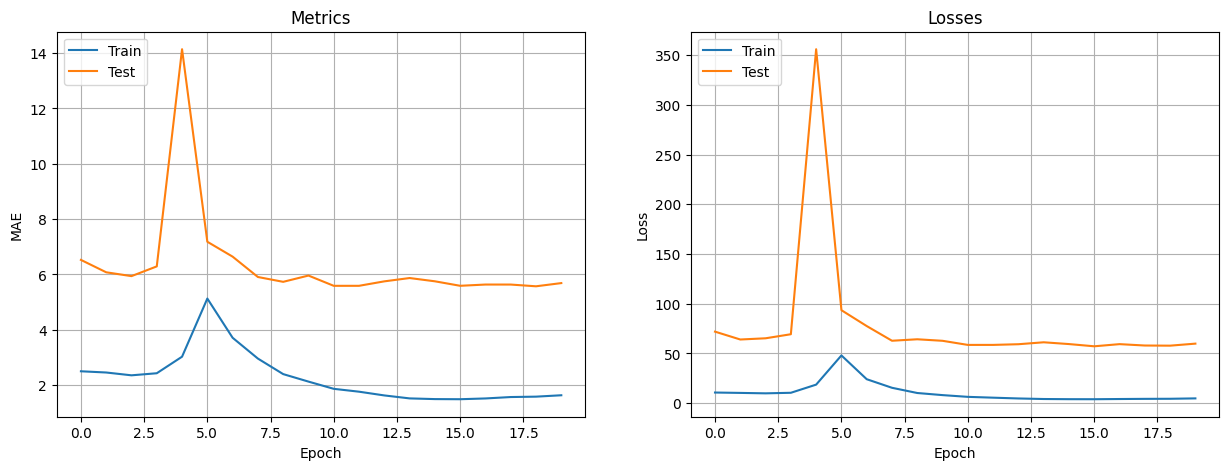

In [ ]:
# построим графики пороцесса обучения
plt.figure(figsize=(15,5))
# метрики модели
plt.subplot(1, 2, 1)
plt.plot(history.history.history['mae'])
plt.plot(history.history.history['val_mae'])
plt.grid(True)
plt.title('Metrics')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# ошибки модели
plt.subplot(1, 2, 2)
plt.plot(history.history.history['loss'])
plt.plot(history.history.history['val_loss'])
plt.grid(True)
plt.title('Losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

##Тест модели

In [ ]:
from PIL import Image
import requests
import h5py
from io import BytesIO
import tensorflow as tf

def load_model_from_h5_url(url):
    # Загрузка файла H5 из URL
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception("Failed to download the H5 file")

    # Создание объекта BytesIO для чтения данных
    h5_data = BytesIO(response.content)

    # Чтение модели из файла H5
    with h5py.File(h5_data, 'r') as h5_file:
        model = tf.keras.models.load_model(h5_file)

    return model

model_url = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/fSXNlTrrJgvVWw'
model_age = load_model_from_h5_url(model_url)

In [ ]:
import zipfile
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

target_test = [4,2,25,35,28,59,80,52,4,16]

def remove_folder(directory):
    if os.path.exists(directory):
        !rm -rf {directory}
        print(f"Папка '{directory}' успешно удалена.")
    else:
        print(f"Папка '{directory}' не существует, поэтому её удаление не требуется.")

remove_folder('/content/test_image')

# Функция для загрузки и разархивации ZIP-папки
def download_and_extract_zip(url, patch):
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception("Failed to download the ZIP file")

    # Разархивация ZIP-папки
    with zipfile.ZipFile(BytesIO(response.content), 'r') as zip_ref:
        zip_ref.extractall(patch)

# URL для скачивания ZIP-папки с изображениями
zip_url = 'https://drive.usercontent.google.com/u/0/uc?id=1cxA9h5DWssgLJz2cLZZQtzGCtULzMnSx&export=download'
download_and_extract_zip(zip_url, '/content/test_image')

1/1 [==============================] - 1s 942ms/step

Значение MAE на батче из тестовой выборки: 3.006


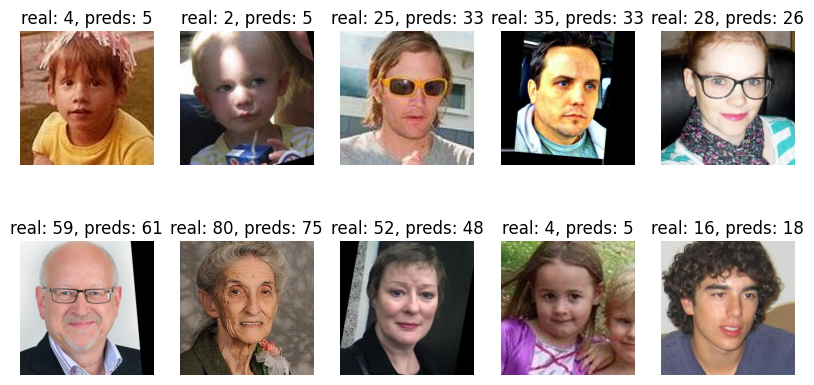

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Путь к папке с изображениями
image_folder = "/content/test_image/test_image/"

# Список для хранения загруженных изображений
test_images = []

# Загрузка и преобразование изображений
for i in range(10):
    image_path = os.path.join(image_folder, f"{i}.jpg")
    image = Image.open(image_path)
    image_resized = image.resize((224, 224))
    image_array = np.array(image_resized) / 255.0
    test_images.append(image_array)

features_test = np.array(test_images)

# Предсказание модели на данных батча
predicted = model_age.predict(features_test)

# Расчёт MAE
mae = mean_absolute_error(target_test, predicted[:,0])

print(f'\nЗначение MAE на батче из тестовой выборки: {mae:.3f}')

# Вывод изображений и предсказанных возрастов
columns = 5
rows = len(predicted) // columns
fig = plt.figure(figsize=(10,5))
for i in range(min(len(predicted), rows * columns)):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(features_test[i])
    plt.axis('off')
    plt.title(f'real: {target_test[i]}, preds: {round(predicted[i][0])}')
plt.show()
